In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize
import pickle
from collections import defaultdict
import random

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
import dexplot as dxp #for easy barplot

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key, chi2_distance, most_frequent
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
rv = 0

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

change the configuration file if not done yet!


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
li_nbr_cluster = range(2,100)
V = 'chi2distance_ALL_15'
name_clustering = 'ALL_MLPS_99'
path_extracted_data_visual_adap_clustering_V = os.path.join(path_extracted_data_visual_adap_clustering, V+'_ALL_MLPS')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [6]:
li_selected_hens = pickle.load(open(os.path.join(path_extracted_data_visual_adap, 'li_selected_hens.pkl'), 'rb'))
print(len(li_selected_hens))
#for now we have only distance restricted to 70 animals
#compute the CHI2DISTANCE & DTW for each bird with all other birds (because we need this exact same pair to do the visual)
#rv = 0
#random.seed(rv)
#nbr_hens = 70
#randomly pick more than one element from the list without repeating elements.
#li_selected_hens = random.sample(li_selected_hens, nbr_hens)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


131


In [7]:
#focal birds info (one row per bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'],
                     dayfirst=True) 
df_FB['percentage_of_gain_weight'] = df_FB.apply(lambda x: (x['weight 23-11-2020']-x['29-09 weight'])/x['29-09 weight']*100, axis=1)
print(df_FB.shape)
df_FB.head(3)

(212, 12)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HenID  PenID CLASS  R-Pen InitialStartDate  29-09 weight  \
0    hen_1      9   EPI    1.0       2020-06-10        1134.0   
1   hen_10     11  LEXP    1.0       2020-06-10        1070.0   
2  hen_100      5   EPI    3.0       2020-06-10        1182.0   

   10-12 juin weight  weight 23-11-2020  weight 04-01-2021  weight 01-02-21  \
0               57.0             1696.5             1787.8           1800.9   
1               70.4             1488.3             1628.4           1602.1   
2               80.5             1642.5                NaN              NaN   

  Treatment  percentage_of_gain_weight  
0       OFH                  49.603175  
1       OFH                  39.093458  
2       OFH                  38.959391

In [8]:
df_res = pd.read_csv(os.path.join(path_extracted_data_visual_adap_clustering_V,id_run+'df_clustering_results.csv'), sep=';',
                     dayfirst=True) 
df_res['DIB'] = df_res['MLPID'].map(lambda x: int(x.split('-')[1]))
df_res['date'] = df_res['DIB'].map(lambda x: dt.datetime(2020,9,29)+dt.timedelta(days=x))
df_res['HenID'] = df_res['MLPID'].map(lambda x: x.split('-')[0])
print(df_res.shape)
df_res.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(5146, 102)


MLPID  ALL_MLPS_2  ALL_MLPS_3  ALL_MLPS_4  ALL_MLPS_5  ALL_MLPS_6  \
0   hen_61-20           1           1           3           1           0   
1   hen_65-35           0           0           1           0           5   
2  hen_138-54           1           1           3           1           0   

   ALL_MLPS_7  ALL_MLPS_8  ALL_MLPS_9  ALL_MLPS_10  ...  ALL_MLPS_93  \
0           0           2           0            5  ...           67   
1           5           5           5            2  ...            9   
2           6           6           2            0  ...           64   

   ALL_MLPS_94  ALL_MLPS_95  ALL_MLPS_96  ALL_MLPS_97  ALL_MLPS_98  \
0           67           67           67           67           67   
1            9            9            4            4            1   
2           64           64           64           64           64   

   ALL_MLPS_99  DIB       date    HenID  
0           67   20 2020-10-19   hen_61  
1            0   35 2020-11-03   hen_65  
2           64   54 2020-11-22  hen_138  

[3 rows x 102 columns]

In [11]:
#add hen info
df_info = pd.merge(df_res, df_FB, on='HenID', how='left')
df_info['WIB'] = df_info['DIB'].map(lambda x: int((x-1)/7)+1)
df_info['PenID'] = df_info['PenID'].map(lambda x: 'pen'+str(x))
df_info[name_clustering] = df_info[name_clustering].map(lambda x: 'cl_'+str(x))
print(df_info.shape)
df_info[['WIB','PenID',name_clustering]].head(3)

(5146, 114)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WIB  PenID ALL_MLPS_99
0    3  pen12       cl_67
1    5  pen10        cl_0
2    8  pen10       cl_64

In [17]:
#CHOOSE NBR OF CLUSTER & MOST IMPORTANT CLUSTER
#lets define it as the animal with the smallest squared average distance to all others from the same cluster
#chose which clustering results oyu want to visualise 
#[i for i in df_ari['clusteringID1'].tolist() if i.startswith('enddayfixed_startingDIB-1_nbrcluster-5_')]
'''for nbr_cl in li_nbr_cluster:   
    name_clustering = 'ALL_MLPS_'+str(nbr_cl)
    print(name_clustering)
    print(df_res[name_clustering].value_counts())'''
name_clustering = 'ALL_MLPS_99'
#first, make clustersID as string to avoid confusion
df_plt = df_info[name_clustering].value_counts().reset_index()
display(df_plt[0:40])

#then, select the 7 most important clusters
li_clmostimportant = df_plt['index'][0:9].tolist()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


index  ALL_MLPS_99
0   cl_67         1904
1   cl_22          727
2    cl_3          475
3   cl_15          350
4    cl_0          274
5    cl_6          157
6    cl_7          133
7   cl_21          131
8   cl_52          112
9   cl_35           68
10  cl_33           68
11  cl_34           44
12  cl_30           44
13   cl_8           38
14  cl_36           37
15  cl_25           37
16   cl_2           24
17  cl_16           24
18  cl_27           20
19  cl_18           20
20  cl_29           19
21  cl_23           18
22   cl_5           17
23   cl_4           16
24  cl_24           16
25  cl_66           15
26  cl_31           15
27  cl_94           14
28  cl_74           14
29  cl_26           14
30  cl_10           12
31  cl_56           12
32  cl_11           12
33   cl_9           11
34  cl_17           11
35  cl_68           10
36  cl_73            8
37  cl_14            8
38  cl_43            7
39  cl_40            7

# Visual potential interactions 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


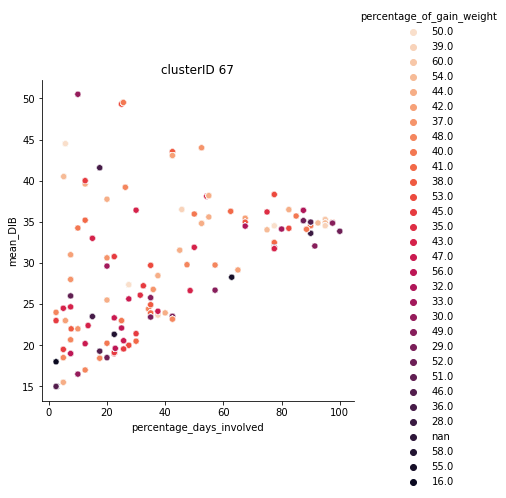

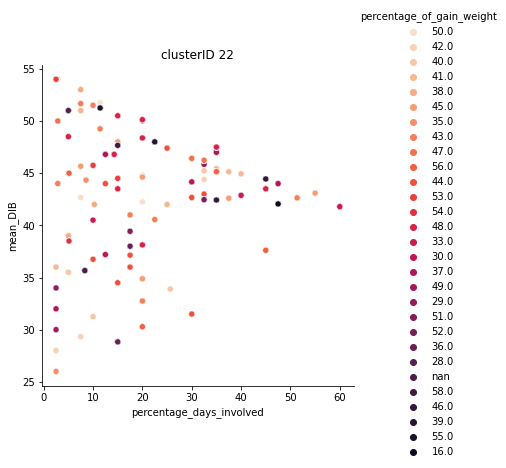

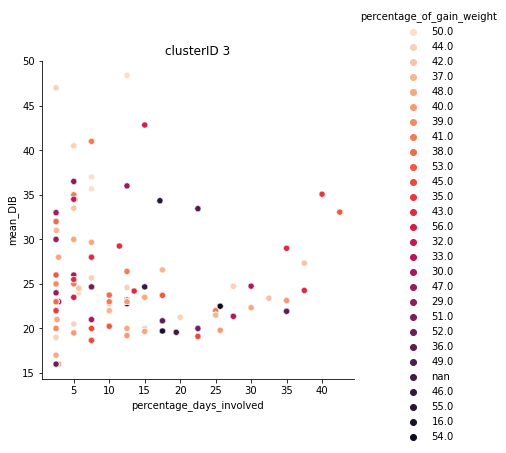

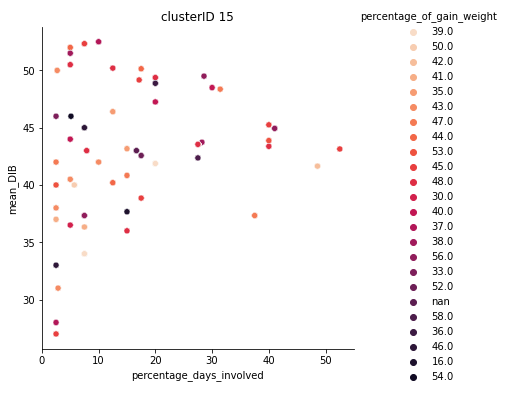

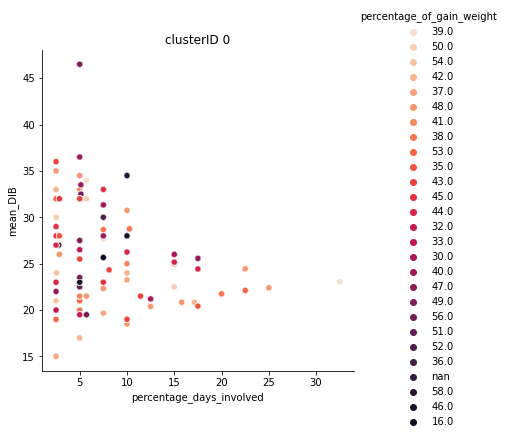

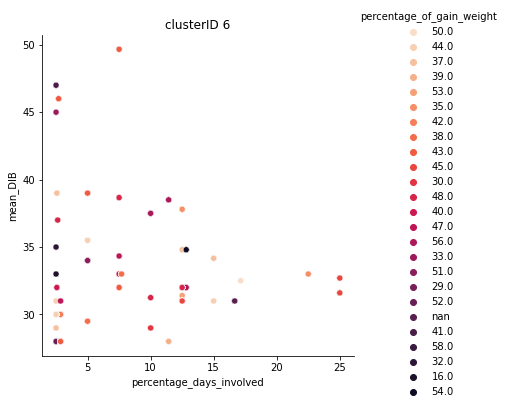

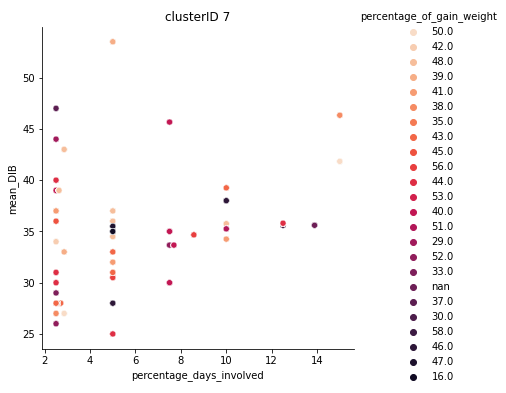

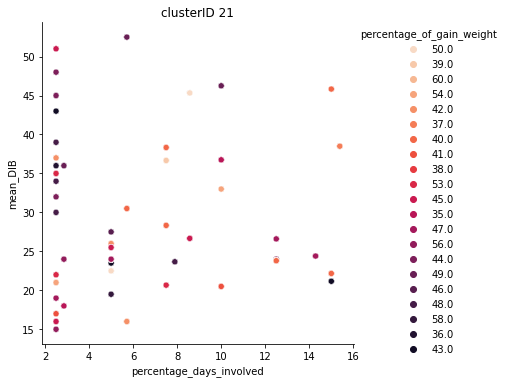

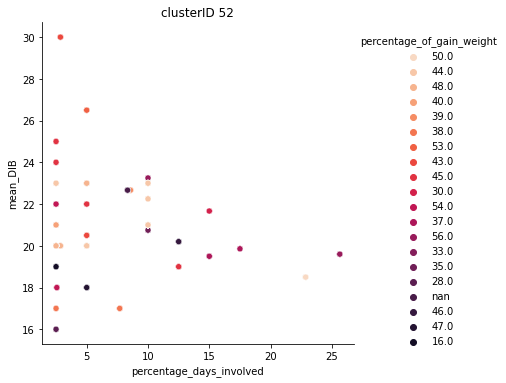

In [18]:
dico_hen_daysinvolved = dict(df_res.groupby(['HenID'])['DIB'].count())

for k in li_clmostimportant:
    k = int(k.split('_')[1])
    df_plt = df_res[df_res[name_clustering]==k].groupby(['HenID'])['DIB'].agg(lambda x: list(x)).reset_index()
    df_plt['percentage_days_involved'] = df_plt.apply(lambda x: len(x['DIB'])/dico_hen_daysinvolved[x['HenID']]*100, axis=1)
    df_plt['mean_DIB'] = df_plt['DIB'].map(lambda x: np.mean(x))
    df_plt = pd.merge(df_plt, df_info, on=['HenID'], how='left')
    df_plt['percentage_of_gain_weight'] = df_plt['percentage_of_gain_weight'].map(lambda x: str(round(x,0)))
    #display(df_plt['percentage_of_gain_weight'].value_counts(normalize=True))
    #display(df_plt.head(3))
    sns.relplot(x="percentage_days_involved", y="mean_DIB", hue="percentage_of_gain_weight", legend="full", data=df_plt,
               palette=sns.color_palette("rocket_r", len(df_plt['percentage_of_gain_weight'].unique())));
    plt.title('clusterID '+str(k))
    plt.show()